In [1]:
# https://pjreddie.com/darknet/yolo/
# https://github.com/AlexeyAB/darknet
# https://dontrepeatyourself.org/post/yolov3-object-detection-with-deep-learning-opencv-and-python/
# https://medium.com/analytics-vidhya/object-detection-with-opencv-python-using-yolov3-481f02c6aa35
# https://github.com/python-dontrepeatyourself/Object-Detection-and-Tracking-with-YOLOv8-and-DeepSORT
# https://towardsdatascience.com/object-detection-using-yolov3-and-opencv-19ee0792a420
# https://github.com/python-dontrepeatyourself/Object-Detection-and-Tracking-with-YOLOv8-and-DeepSORT

In [2]:
import cv2
import numpy as np
import glob, os
from IPython.display import Image

In [3]:
# define the minimum confidence (to filter weak detections), 
# Non-Maximum Suppression (NMS) threshold, and the green color
confidence_thresh = 0.5
NMS_thresh = 0.3
green = (0, 255, 0)

#Yolo Config
yolo_config =   '/kaggle/input/private-dataset/yolov3.cfg'
yolo_weights =  '/kaggle/input/private-dataset/yolov3.weights'
coco_names =    '/kaggle/input/private-dataset/coco.names'

# Load the image and get its dimensions
image = cv2.imread("/kaggle/input/private-dataset/1.jpg")

#image resize
resize = 1

In [4]:
# resize the image
image = cv2.resize(image, (int(image.shape[0] * resize), int(image.shape[1] * resize)))

# get the image dimensions
h = image.shape[0]
w = image.shape[1]

In [5]:
net = cv2.dnn.readNet(yolo_weights,yolo_config)
classes = []
with open(coco_names,"r") as f:
    classes = [line.strip() for line in f.readlines()]

In [6]:
# Get the name of all the layers in the network
layer_names = net.getLayerNames()

# Get the names of the output layers
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

In [7]:
# load YOLOv3 network pre-trained on the COCO dataset
net = cv2.dnn.readNetFromDarknet(yolo_config, yolo_weights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [8]:
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

In [9]:
# create a blob from the image
blob = cv2.dnn.blobFromImage(
    image, 1 / 255, (416, 416), swapRB=True, crop=False)
# pass the blob through the network and get the output predictions
net.setInput(blob)
outputs = net.forward(output_layers)

[ WARN:0@3.526] global net_impl.cpp:178 setUpNet DNN module was not built with CUDA backend; switching to CPU


In [10]:
print(len(outputs))
print(outputs[0].shape)
print(outputs[1].shape)
print(outputs[2].shape)

3
(507, 85)
(2028, 85)
(8112, 85)


In [11]:
# create empty lists for storing the bounding boxes, confidences, and class IDs
boxes = []
confidences = []
class_ids = []

# loop over the output predictions
for output in outputs:
    # loop over the detections
    for detection in output:
        # get the class ID and confidence of the dected object
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence  = scores[class_id]

        # we keep the bounding boxes if the confidence (i.e. class probability) 
        # is greater than the minimum confidence 
        if confidence > confidence_thresh:
            # perform element-wise multiplication to get
            # the coordinates of the bounding box
            box = [int(a * b) for a, b in zip(detection[0:4], [w, h, w, h])]
            center_x, center_y, width, height = box

            # get the top-left corner of the bounding box
            x = int(center_x - (width / 2))
            y = int(center_y - (height / 2))

            # append the bounding box, confidence, and class ID to their respective lists
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([x, y, width, height])

In [12]:
x = int(center_x - (width / 2))
y = int(center_y - (height / 2))

In [13]:
# apply non-maximum suppression to remove weak bounding boxes that overlap with others.
indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence_thresh, NMS_thresh)
indices = indices.flatten()
for i in indices:
    (x, y, w, h) = boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]
    cv2.rectangle(image, (x, y), (x + w, y + h), green, 2)
    text = f"{classes[class_ids[i]]}: {confidences[i] * 100:.2f}%"
    cv2.putText(image, text, (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, green, 2)

# Save the resulting image
cv2.imwrite("result_image.jpg", image)
# show the output image
#cv2.imshow("After NMS", image)
#cv2.waitKey(0)

True

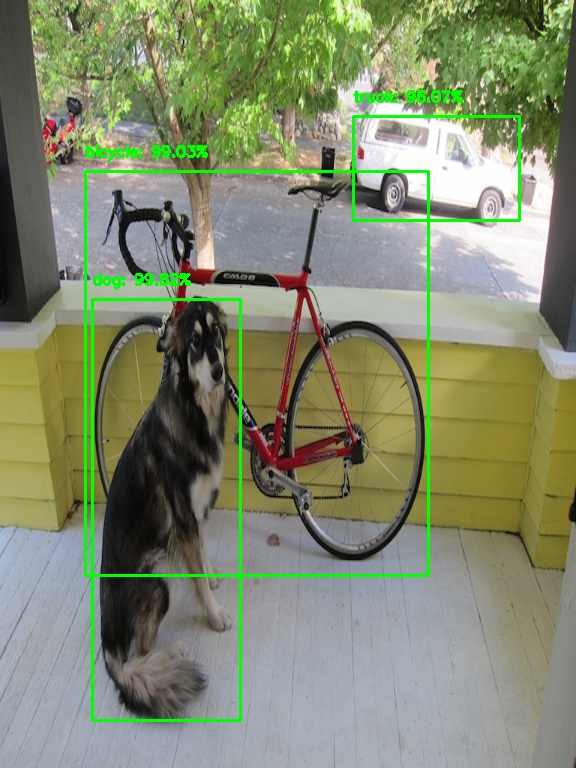

In [14]:
Image(filename='result_image.jpg') 

# USE VIDEO

In [15]:
# Load the video
video_path = '/kaggle/input/private-dataset/Front-20240321175231-20240321175337.mp4'
cap = cv2.VideoCapture(video_path)

In [16]:
# Set the scale factor for resizing
scale_factor = 1

# Set the frame skip rate
frame_skip = 100  # Skip every 5th frame

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

print(frame_width)
print(frame_height)
print(fps)

2560
1920
30


In [17]:
# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
output_video_path = 'output_video.avi'
out_vid = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

In [18]:
frame_count = 0  # Initialize frame count

while True:
    
    # Read a new frame
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1  # Increment frame count

    # Skip frames if necessary
    if frame_count % frame_skip != 0:
        continue

    # Resize frame
    resized_frame = cv2.resize(frame, None, fx=scale_factor, fy=scale_factor)

    # Perform YOLO object detection
    blob = cv2.dnn.blobFromImage(resized_frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    # create empty lists for storing the bounding boxes, confidences, and class IDs
    boxes = []
    confidences = []
    class_ids = []
    
    # Process detection results
    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                
                # Object detected
                center_x = int(detection[0] * frame_width)
                center_y = int(detection[1] * frame_height)
                w = int(detection[2] * frame_width)
                h = int(detection[3] * frame_height)
                
                # Draw bounding box
                cv2.rectangle(frame, (center_x - w // 2, center_y - h // 2), (center_x + w // 2, center_y + h // 2), (0, 255, 0), 2)
                text = classes[class_id]
                cv2.putText(frame, text, (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, green, 2)
                
                # append the bounding box, confidence, and class ID to their respective lists
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, width, height])
                
    # apply non-maximum suppression to remove weak bounding boxes that overlap with others.
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confidence_thresh, NMS_thresh)
    indices = indices.flatten()
                                
    for i in indices:
        (x, y, w, h) = boxes[i][0], boxes[i][1], boxes[i][2], boxes[i][3]
        cv2.rectangle(frame, (x, y), (x + w, y + h), green, 2)
        text = f"{classes[class_ids[i]]}: {confidences[i] * 100:.2f}%"
        cv2.putText(frame, text, (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, green, 2)

    # Write the frame with bounding boxes to the output video
    out_vid.write(frame)
    #out.write(resized_frame)
    
    # Save the resulting image
    cv2.imwrite("result_image_" +str(frame_count)+".jpg", frame)

    # Display frame (optional)
    #cv2.imshow("YOLO Object Detection", frame)
   
# Release video capture and close windows
cap.release()
out_vid.release()

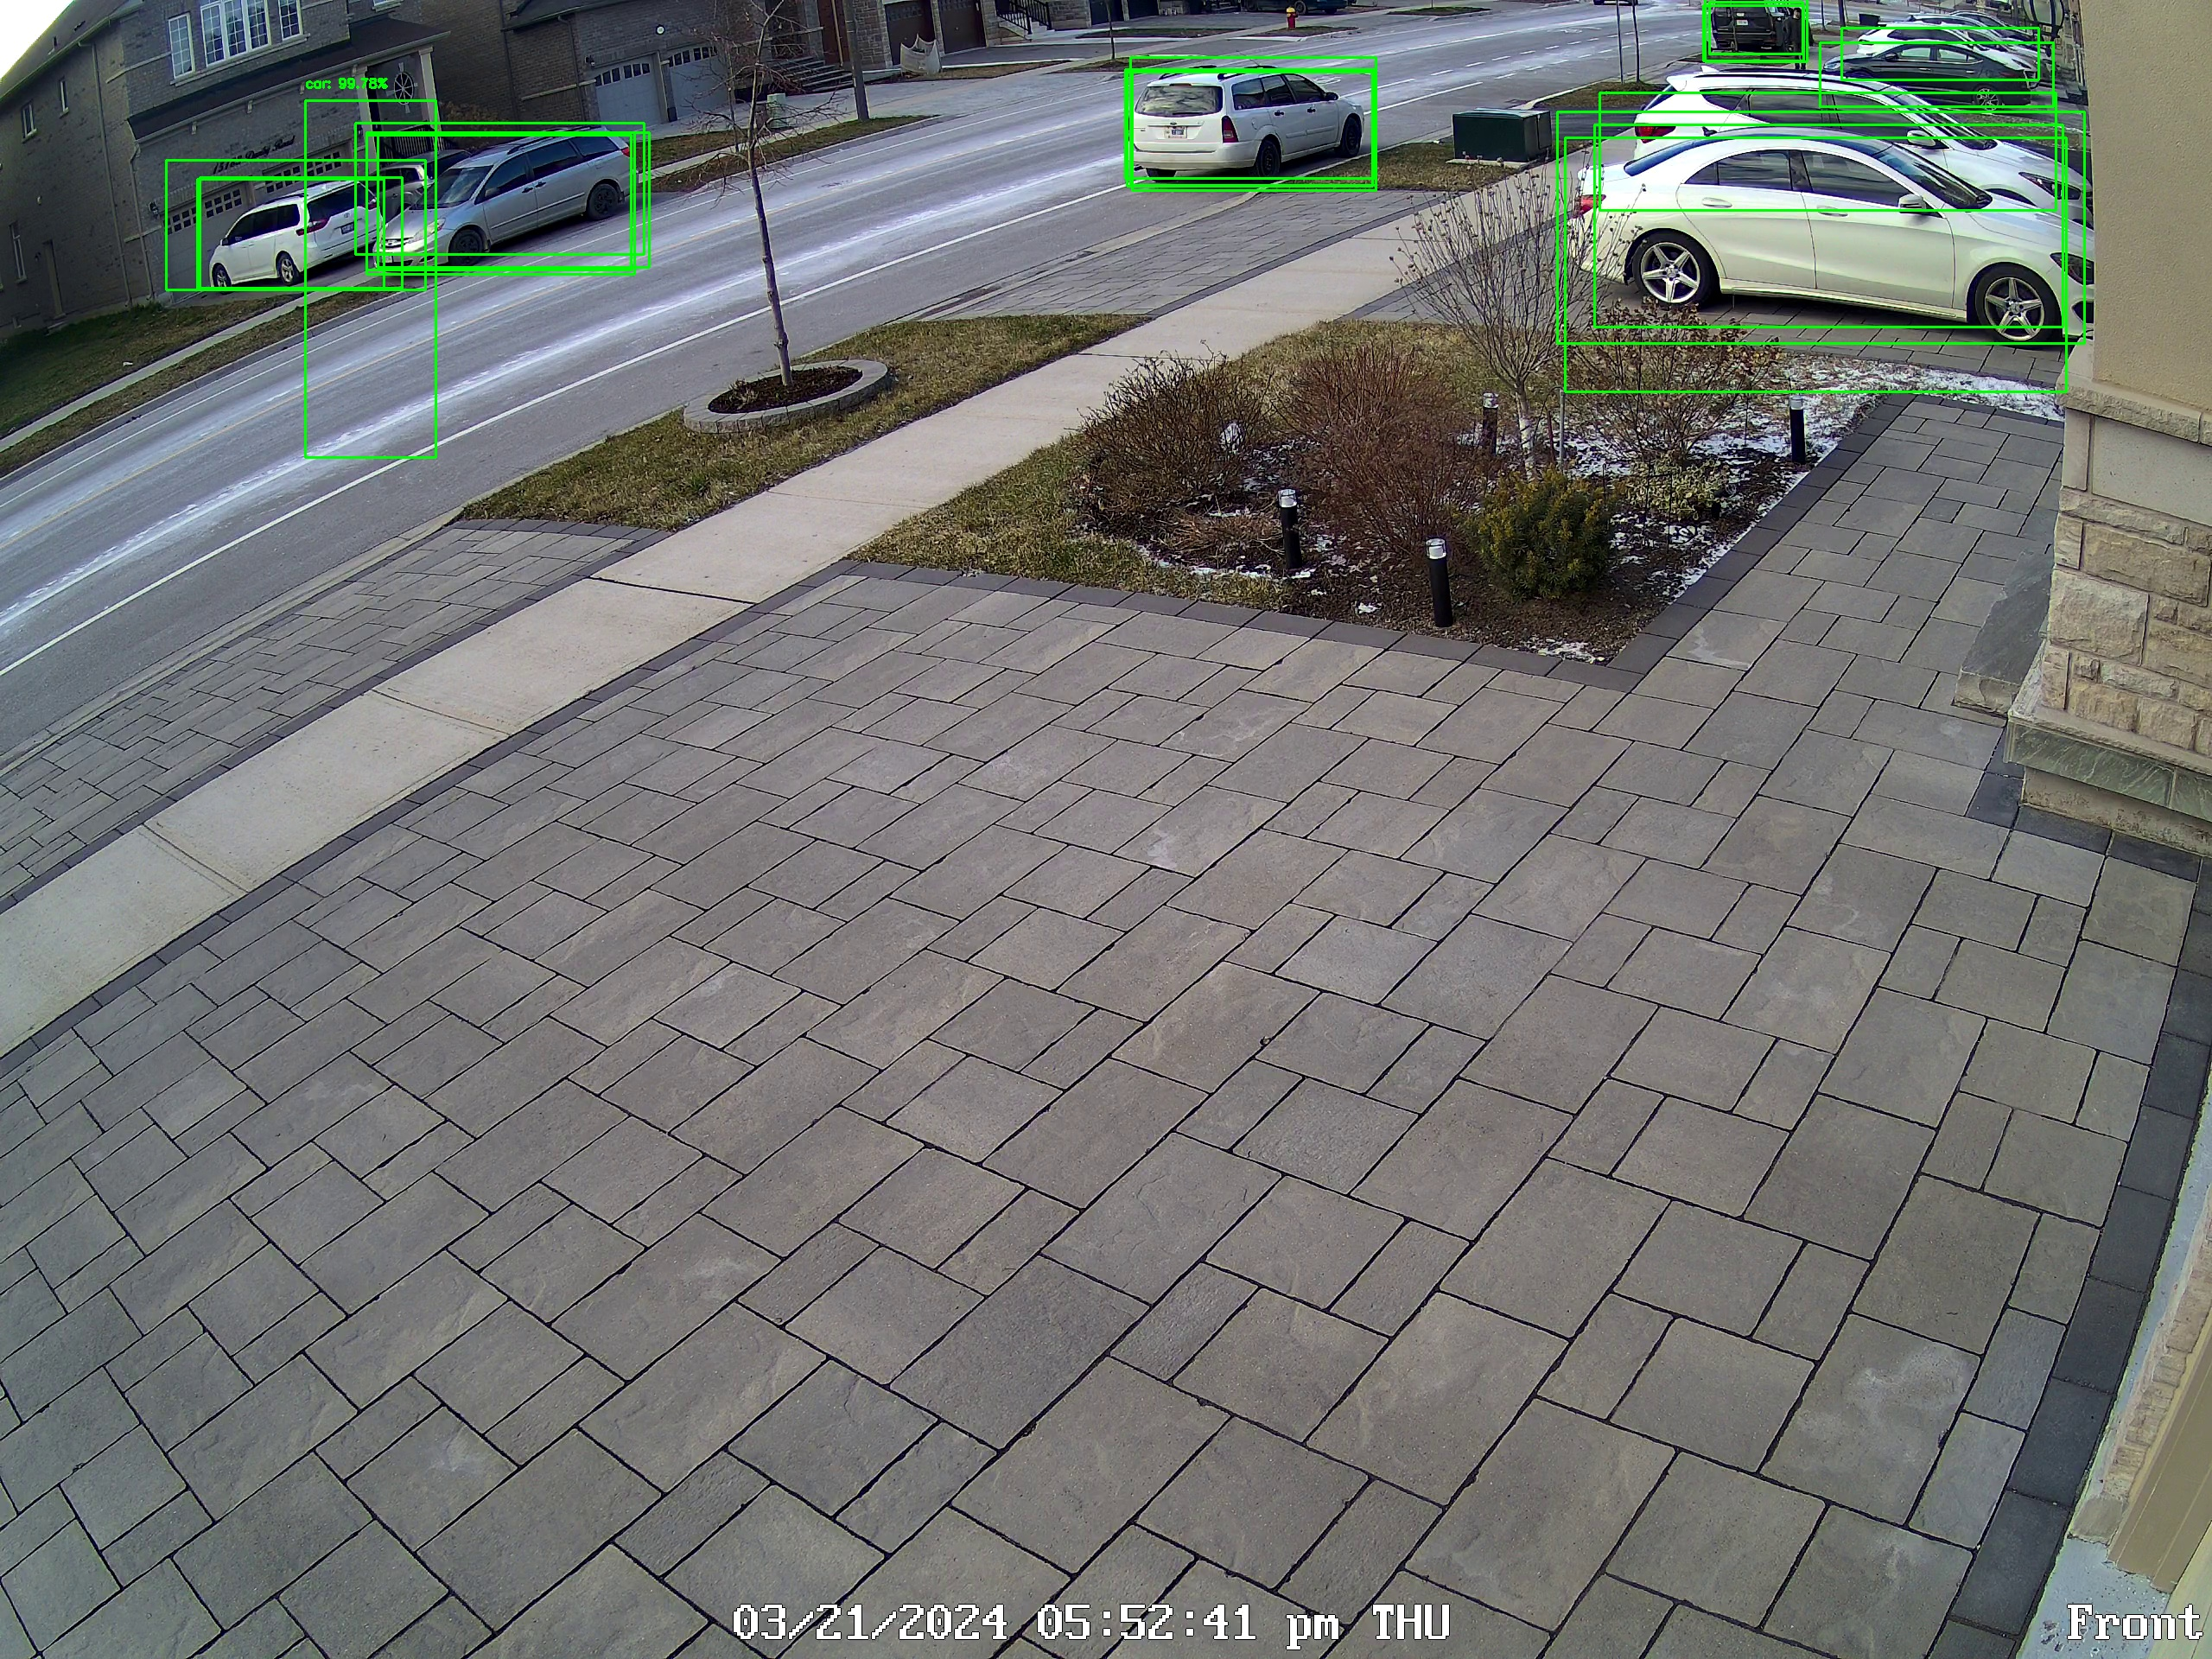

In [19]:
Image(filename='result_image_300.jpg') 

In [20]:
fileList = glob.glob('/kaggle/working/*jpg' , recursive=True)
fileList.sort()

In [21]:
"""
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
to_pil = transforms.ToPILImage()

counter = 0
images = ['result_image_200.jpg','result_image_100.jpg']

while counter < 2:    
        
    fig=plt.figure(figsize=(17,17))
    for ii in range(len(images)):
        image = to_pil(images[ii])
        sub = fig.add_subplot(1, len(images), ii+1)
        res = int(labels[ii])
        plt.axis('off')
        plt.imshow(image)
    
    plt.show()
    counter = counter + 1
"""

"\nimport matplotlib.pyplot as plt\nfrom torchvision import datasets, transforms, models\nto_pil = transforms.ToPILImage()\n\ncounter = 0\nimages = ['result_image_200.jpg','result_image_100.jpg']\n\nwhile counter < 2:    \n        \n    fig=plt.figure(figsize=(17,17))\n    for ii in range(len(images)):\n        image = to_pil(images[ii])\n        sub = fig.add_subplot(1, len(images), ii+1)\n        res = int(labels[ii])\n        plt.axis('off')\n        plt.imshow(image)\n    \n    plt.show()\n    counter = counter + 1\n"